# Individual Assignment 2

Author: Grant Nitta

Date Created: 4/29/2025

Date Last Modified 4/29/2025

# Questions & Answers

## which columns have drift?
- num_feature_3
- num_feature_5
- num_feature_8
- num_feature_10
- cat_feature_2

## approximately when does the column drift? 
- num_feature_3
  - 2023-01-20 to 2023-02-06
- num_feature_5
  - 2023-01-14 to 2023-02-06
- num_feature_8
  - 2023-01-11 to 2023-01-24
  - 2023-01-30 to 2023-02-06
- num_feature_10
  - 2023-01-14 to 2023-01-14
  - 2023-01-31 to 2023-01-31
  - 2023-02-04 to 2023-02-06
- cat_feature_2
  - 2023-01-29 to 2023-02-06

## how many times does the column drift?
- num_feature_3
  - 1
- num_feature_5
  - 1
- num_feature_8
  - 2
- num_feature_10
  - 3
- cat_feature_2
  - 1

# Library Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency
import datetime
from matplotlib.dates import DateFormatter
import warnings

# Data Importation & EDA

In [2]:
synthetic = pd.read_csv("synthetic_data.csv")

synthetic["datetime"] = pd.to_datetime(synthetic["datetime"])

/var/folders/3c/x1npc5yj6655gwzm358m5plh0000gn/T/ipykernel_60656/3142850510.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  synthetic["datetime"] = pd.to_datetime(synthetic["datetime"])


In [3]:
synthetic.head()

datetime  num_feature_1  num_feature_2  num_feature_3  \
0 2023-01-01 00:00:00       0.496714       0.029431      -0.567379   
1 2023-01-01 00:10:00      -0.138264       0.516644      -0.362385   
2 2023-01-01 00:20:00       0.647689      -0.981326       0.099534   
3 2023-01-01 00:30:00       1.523030      -1.404817       0.218030   
4 2023-01-01 00:40:00      -0.234153       0.107208       0.434959   

   num_feature_4  num_feature_5  num_feature_6  num_feature_7  num_feature_8  \
0       1.316345       0.981826       0.245528      -0.295666       0.587933   
1      -2.908661       0.999686       0.558558       0.383567      -0.179220   
2      -1.222750       0.040974       0.590688       1.039632       0.962875   
3      -0.915632       0.208394      -1.408984      -1.036513      -1.255305   
4      -0.819715      -1.429766       0.824087       1.010910      -0.535573   

   num_feature_9  num_feature_10 cat_feature_1 cat_feature_2 cat_feature_3  
0      -1.207989       -0.362931             A             X             C  
1      -1.071735       -0.673647             B             Z             C  
2       0.379122       -1.458926             C             X             A  
3       1.052502       -2.704705             C             Z             B  
4       1.037141       -1.826844             C             X             B

In [4]:
synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        5760 non-null   datetime64[ns]
 1   num_feature_1   5760 non-null   float64       
 2   num_feature_2   5760 non-null   float64       
 3   num_feature_3   5760 non-null   float64       
 4   num_feature_4   5760 non-null   float64       
 5   num_feature_5   5760 non-null   float64       
 6   num_feature_6   5760 non-null   float64       
 7   num_feature_7   5760 non-null   float64       
 8   num_feature_8   5760 non-null   float64       
 9   num_feature_9   5760 non-null   float64       
 10  num_feature_10  5760 non-null   float64       
 11  cat_feature_1   5760 non-null   object        
 12  cat_feature_2   5760 non-null   object        
 13  cat_feature_3   5760 non-null   object        
dtypes: datetime64[ns](1), float64(10), object(3)
memory usag

# Analysis

In [5]:
def detect_numerical_drift(
    df, feature, reference_start, reference_end, window_size, step_size=1
):
    # Get reference data
    reference_data = df[
        (df["datetime"] >= reference_start) & (df["datetime"] <= reference_end)
    ][feature]

    # Initialize results storage
    results = []

    # Iterate through the dataset with a moving window
    current_date = reference_end + pd.Timedelta(days=1)
    end_date = df["datetime"].max()

    while current_date + pd.Timedelta(days=window_size - 1) <= end_date:
        window_end = current_date + pd.Timedelta(days=window_size - 1)

        # Get test data for current window
        test_data = df[
            (df["datetime"] >= current_date) & (df["datetime"] <= window_end)
        ][feature]

        # Calculate KS statistic and p-value
        ks_stat, p_value = ks_2samp(reference_data, test_data)

        # Store results
        results.append(
            {
                "window_start": current_date,
                "window_end": window_end,
                "window_mid": current_date
                + pd.Timedelta(days=window_size // 2),
                "ks_statistic": ks_stat,
                "p_value": p_value,
            }
        )

        # Move window
        current_date += pd.Timedelta(days=step_size)

    return pd.DataFrame(results)

In [6]:
def detect_categorical_drift(
    df, feature, reference_start, reference_end, window_size, step_size=1
):
    # Get reference data
    reference_data = df[
        (df["datetime"] >= reference_start) & (df["datetime"] <= reference_end)
    ]
    reference_counts = pd.crosstab(
        index=reference_data[feature], columns="count"
    )

    # Initialize results storage
    results = []

    # Iterate through the dataset with a moving window
    current_date = reference_end + pd.Timedelta(days=1)
    end_date = df["datetime"].max()

    while current_date + pd.Timedelta(days=window_size - 1) <= end_date:
        window_end = current_date + pd.Timedelta(days=window_size - 1)

        # Get test data for current window
        test_data = df[
            (df["datetime"] >= current_date) & (df["datetime"] <= window_end)
        ]
        test_counts = pd.crosstab(index=test_data[feature], columns="count")

        # Ensure both dataframes have the same categories
        all_categories = sorted(
            set(reference_counts.index) | set(test_counts.index)
        )
        ref_counts_aligned = pd.Series(
            [
                (
                    reference_counts.loc[cat, "count"]
                    if cat in reference_counts.index
                    else 0
                )
                for cat in all_categories
            ],
            index=all_categories,
        )
        test_counts_aligned = pd.Series(
            [
                test_counts.loc[cat, "count"] if cat in test_counts.index else 0
                for cat in all_categories
            ],
            index=all_categories,
        )

        # Check if there's enough data
        if sum(ref_counts_aligned) > 0 and sum(test_counts_aligned) > 0:
            # Calculate Chi-Square statistic and p-value
            contingency_table = np.vstack(
                [ref_counts_aligned, test_counts_aligned]
            )
            try:
                chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
            except:
                chi2_stat, p_value = np.nan, np.nan
        else:
            chi2_stat, p_value = np.nan, np.nan

        # Store results
        results.append(
            {
                "window_start": current_date,
                "window_end": window_end,
                "window_mid": current_date
                + pd.Timedelta(days=window_size // 2),
                "chi2_statistic": chi2_stat,
                "p_value": p_value,
            }
        )

        # Move window
        current_date += pd.Timedelta(days=step_size)

    return pd.DataFrame(results)

In [7]:
def plot_drift_metrics(
    results_df,
    feature_name,
    metric_col,
    p_value_col,
    threshold=0.05,
    is_numerical=True,
):
    plt.figure(figsize=(14, 6))

    # Plot metric
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(
        results_df["window_mid"], results_df[metric_col], "b-", label=metric_col
    )
    plt.ylabel(metric_col)
    plt.title(f"Drift Analysis for {feature_name}")
    plt.grid(True)
    plt.legend()

    # Plot p-value
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(
        results_df["window_mid"],
        results_df[p_value_col],
        "r-",
        label=p_value_col,
    )
    plt.axhline(
        y=threshold, color="g", linestyle="--", label=f"Threshold ({threshold})"
    )
    plt.ylabel(p_value_col)
    plt.xlabel("Window midpoint")
    plt.grid(True)
    plt.legend()

    # Format date axis
    date_form = DateFormatter("%Y-%m-%d")
    ax2.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)

    plt.tight_layout()

    test_type = "KS test" if is_numerical else "Chi-Square test"
    drifts = sum(results_df[p_value_col] < threshold)
    drift_dates = results_df[results_df[p_value_col] < threshold][
        "window_mid"
    ].tolist()

    if drifts > 0:
        first_drift = min(drift_dates)
        print(f"Feature '{feature_name}' shows drift ({test_type}).")
        print(f"First drift detected around: {first_drift.date()}")
        print(f"Total number of windows with drift: {drifts}")

        # Identify distinct drift periods
        drift_windows = results_df[results_df[p_value_col] < threshold]
        if len(drift_windows) > 0:
            # Convert to dates for easier comparison
            dates = [d.date() for d in drift_windows["window_mid"]]

            # Initialize with the first date
            drift_periods = []
            current_period = [dates[0]]

            # Group consecutive dates
            for i in range(1, len(dates)):
                prev_date = dates[i - 1]
                curr_date = dates[i]

                # If dates are consecutive (or within 2 days of each other)
                if (curr_date - prev_date).days <= 2:
                    current_period.append(curr_date)
                else:
                    drift_periods.append(current_period)
                    current_period = [curr_date]

            # Add the last period
            if current_period:
                drift_periods.append(current_period)

            print(f"Number of distinct drift periods: {len(drift_periods)}")
            for i, period in enumerate(drift_periods):
                print(f"  Drift period {i+1}: {min(period)} to {max(period)}")
    else:
        print(
            f"Feature '{feature_name}' does not show significant drift ({test_type})."
        )

    print("-" * 80)

In [17]:
def plot_drift_summary(df, numerical_drift_results, categorical_drift_results):
    plt.figure(figsize=(15, 8))

    features = numerical_cols + categorical_cols
    y_pos = range(len(features))

    drift_starts = []
    drift_periods = []

    for feature in features:
        if feature in numerical_cols:
            results = numerical_drift_results[feature]
            drift_windows = results[results["p_value"] < 0.05]
        else:
            results = categorical_drift_results[feature]
            drift_windows = results[results["p_value"] < 0.05]

        if len(drift_windows) > 0:
            drift_starts.append(min(drift_windows["window_mid"]))

            # Find continuous drift periods
            dates = sorted([d for d in drift_windows["window_mid"]])

            # Initialize periods
            periods = []
            current_period = [dates[0]]

            # Group consecutive dates
            for i in range(1, len(dates)):
                prev_date = dates[i - 1]
                curr_date = dates[i]

                if (
                    curr_date - prev_date
                ).days <= 2:  # Consider drift continuous if gap is <= 2 days
                    current_period.append(curr_date)
                else:
                    periods.append((min(current_period), max(current_period)))
                    current_period = [curr_date]

            # Add the last period
            if current_period:
                periods.append((min(current_period), max(current_period)))

            drift_periods.append(periods)
        else:
            drift_starts.append(None)
            drift_periods.append([])

    # Plot drift timelines
    date_range = pd.date_range(
        start=df["datetime"].min(), end=df["datetime"].max()
    )

    for i, feature in enumerate(features):
        if drift_periods[i]:
            for start, end in drift_periods[i]:
                plt.plot([start, end], [i, i], "ro-", linewidth=2)

        plt.text(-0.01, i, feature, ha="right", va="center")

    plt.yticks([])
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.title("Drift Timeline by Feature")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

In [9]:
reference_start = synthetic["datetime"].min()
reference_end = reference_start + pd.Timedelta(days=6)  # 7 days (0-6)
window_size = 7  # 7 days
step_size = 1

numerical_cols = synthetic.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
categorical_cols = synthetic.select_dtypes(include=["object"]).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != "datetime"]


NUMERICAL FEATURES DRIFT ANALYSIS
Feature 'num_feature_1' does not show significant drift (KS test).
--------------------------------------------------------------------------------
Feature 'num_feature_2' does not show significant drift (KS test).
--------------------------------------------------------------------------------
Feature 'num_feature_3' shows drift (KS test).
First drift detected around: 2023-01-20
Total number of windows with drift: 18
Number of distinct drift periods: 1
  Drift period 1: 2023-01-20 to 2023-02-06
--------------------------------------------------------------------------------
Feature 'num_feature_4' does not show significant drift (KS test).
--------------------------------------------------------------------------------
Feature 'num_feature_5' shows drift (KS test).
First drift detected around: 2023-01-14
Total number of windows with drift: 24
Number of distinct drift periods: 1
  Drift period 1: 2023-01-14 to 2023-02-06
------------------------------

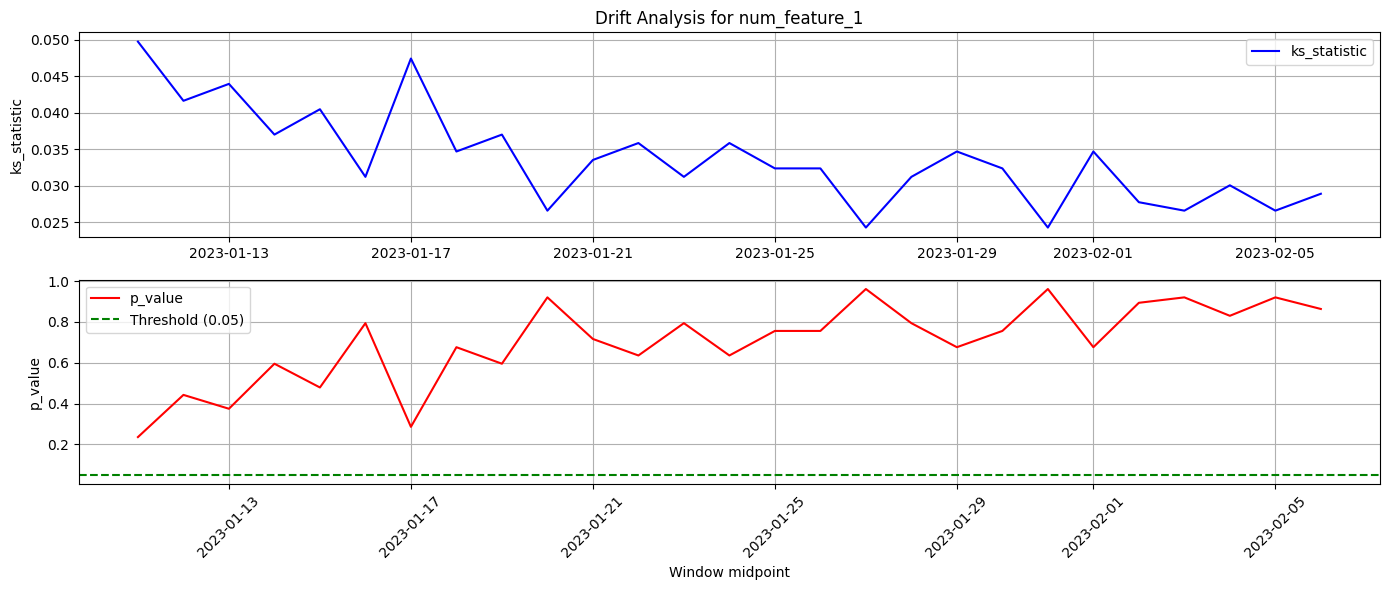

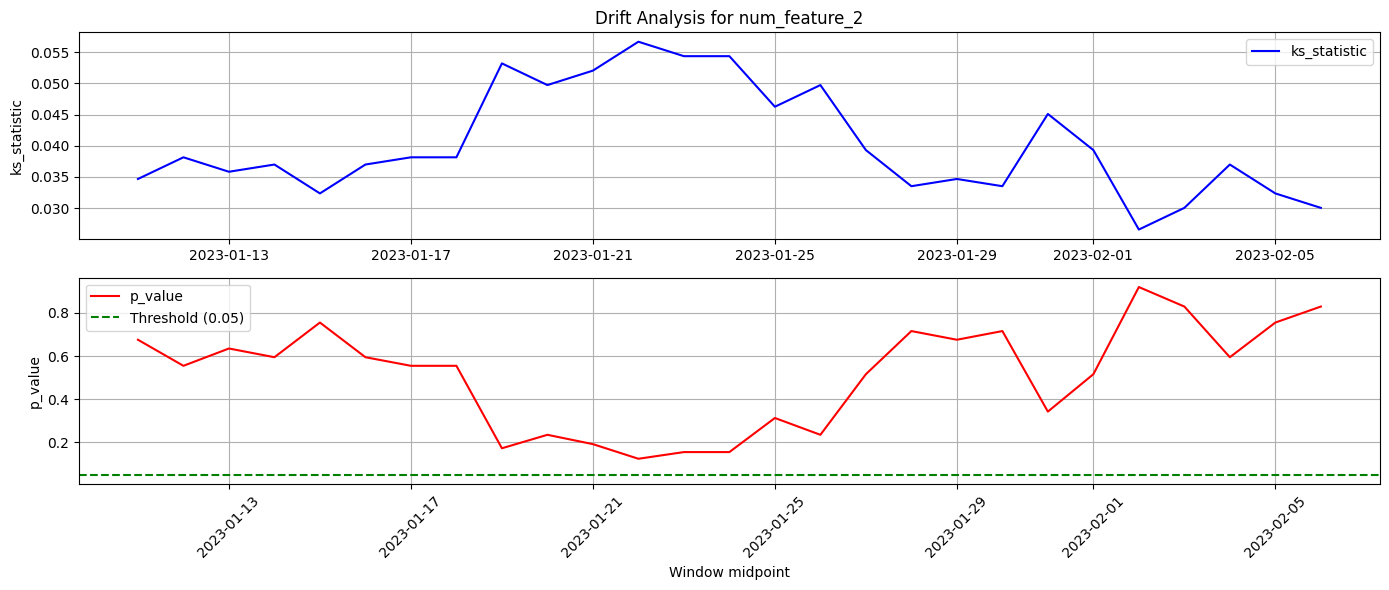

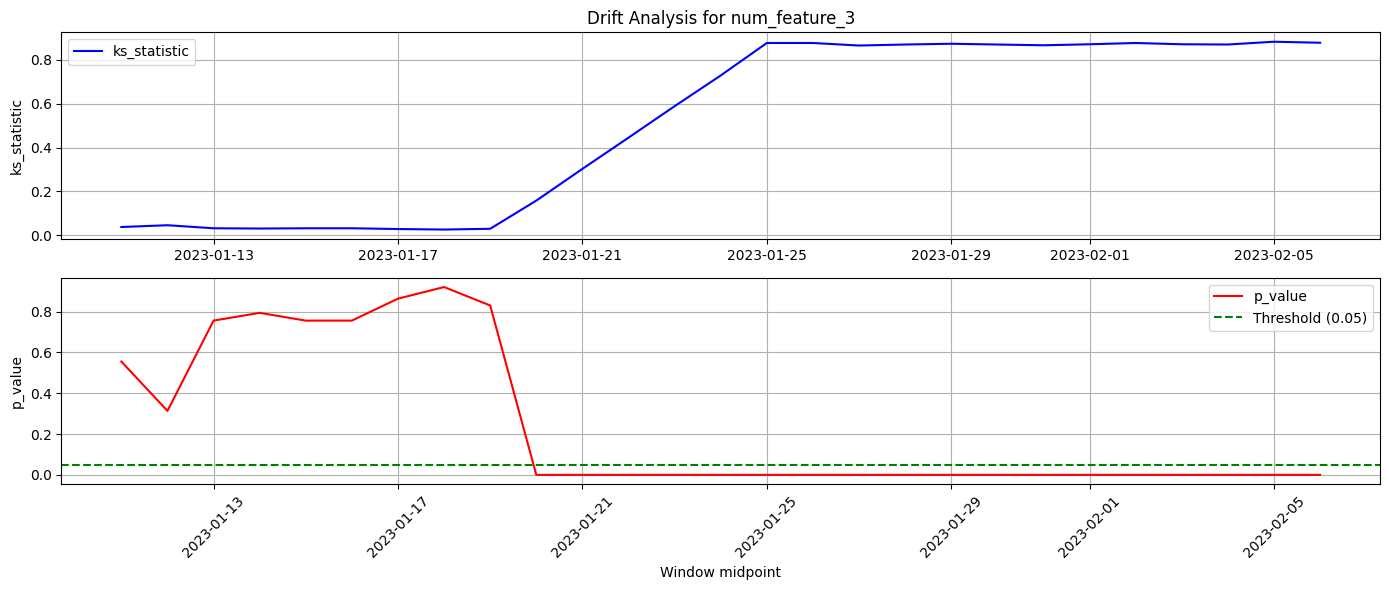

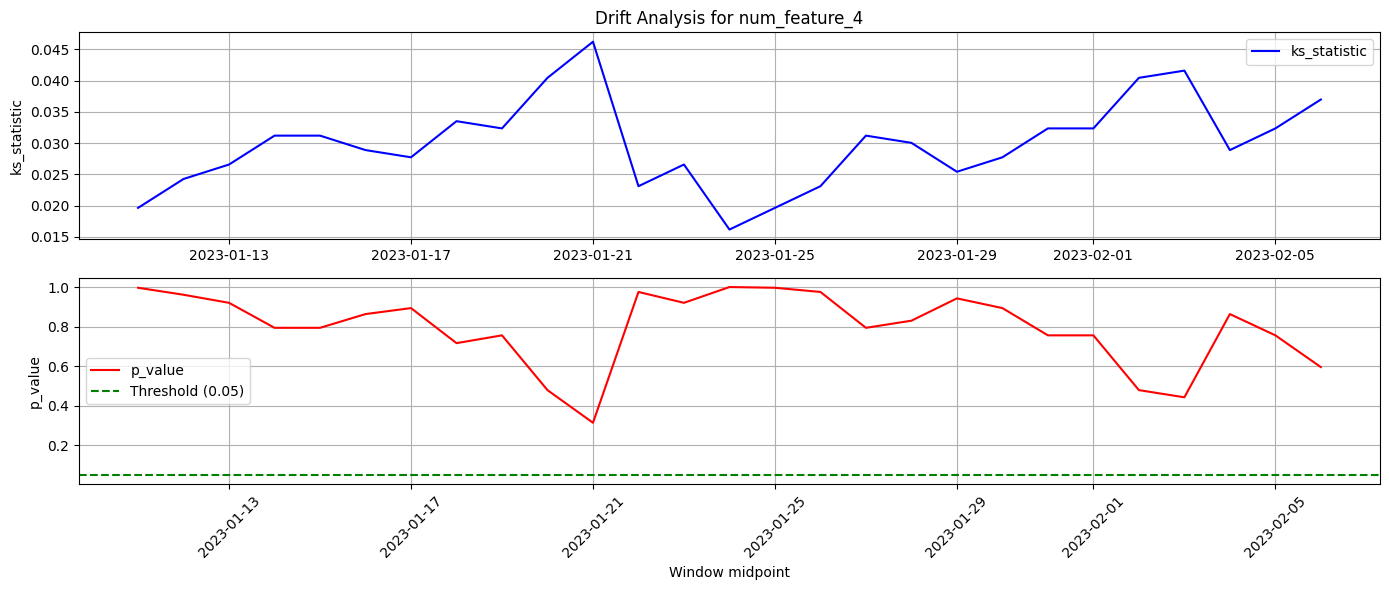

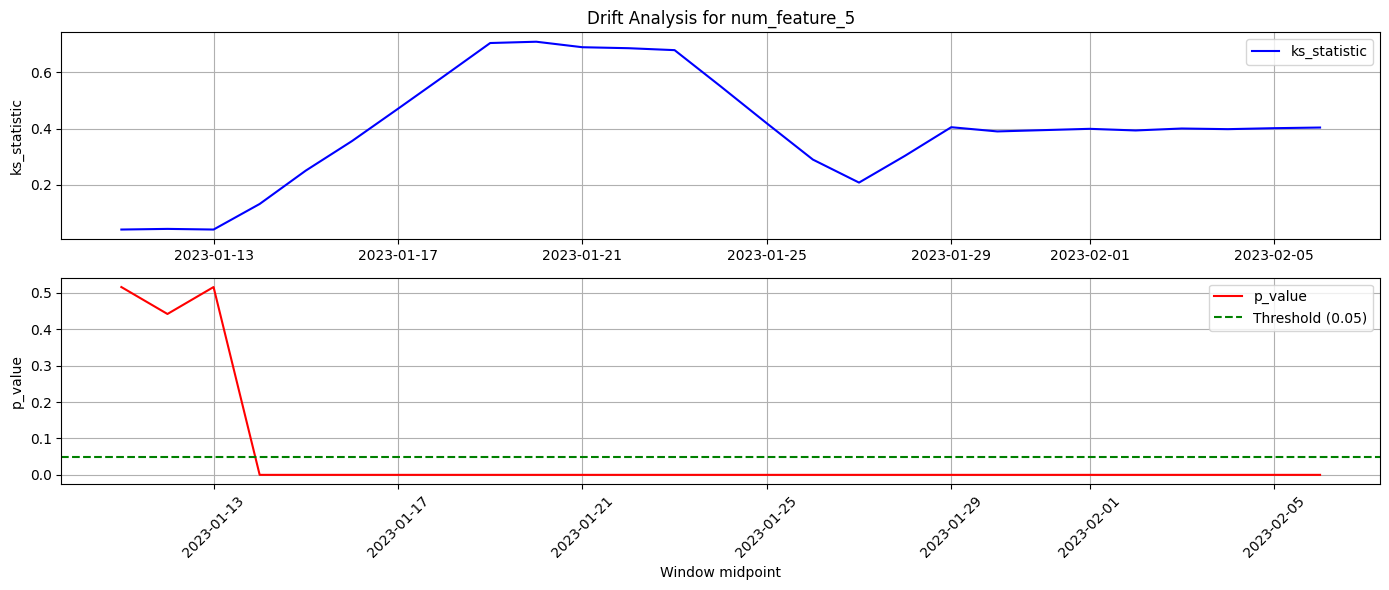

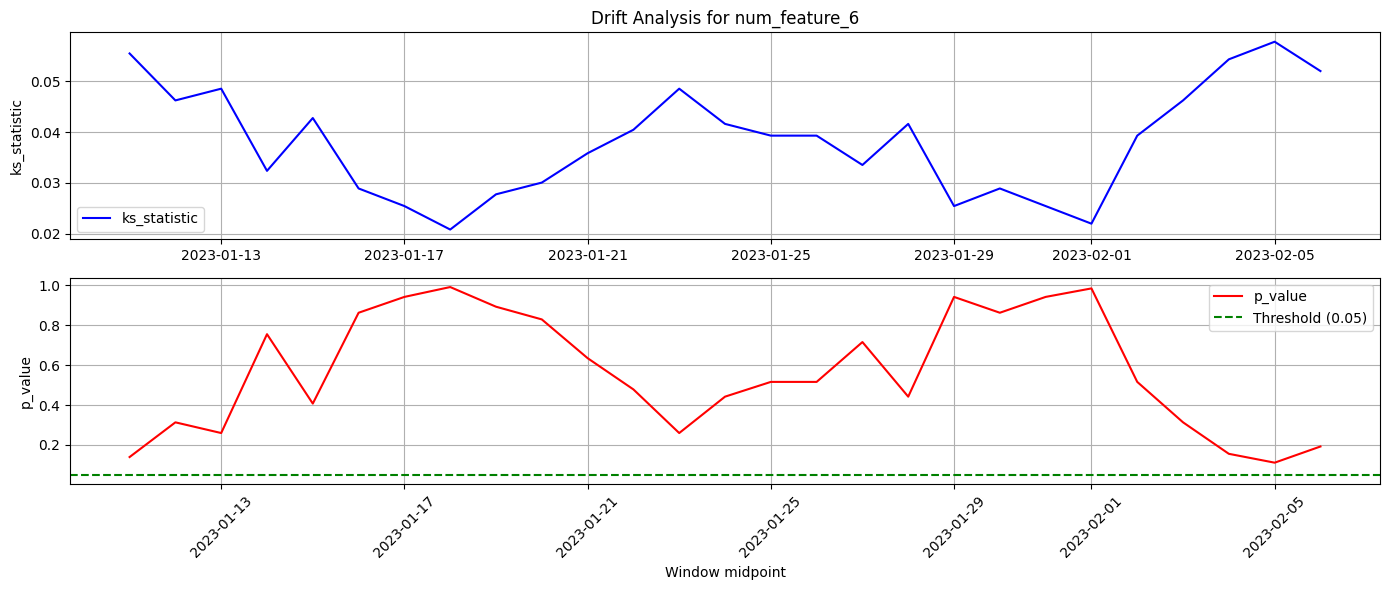

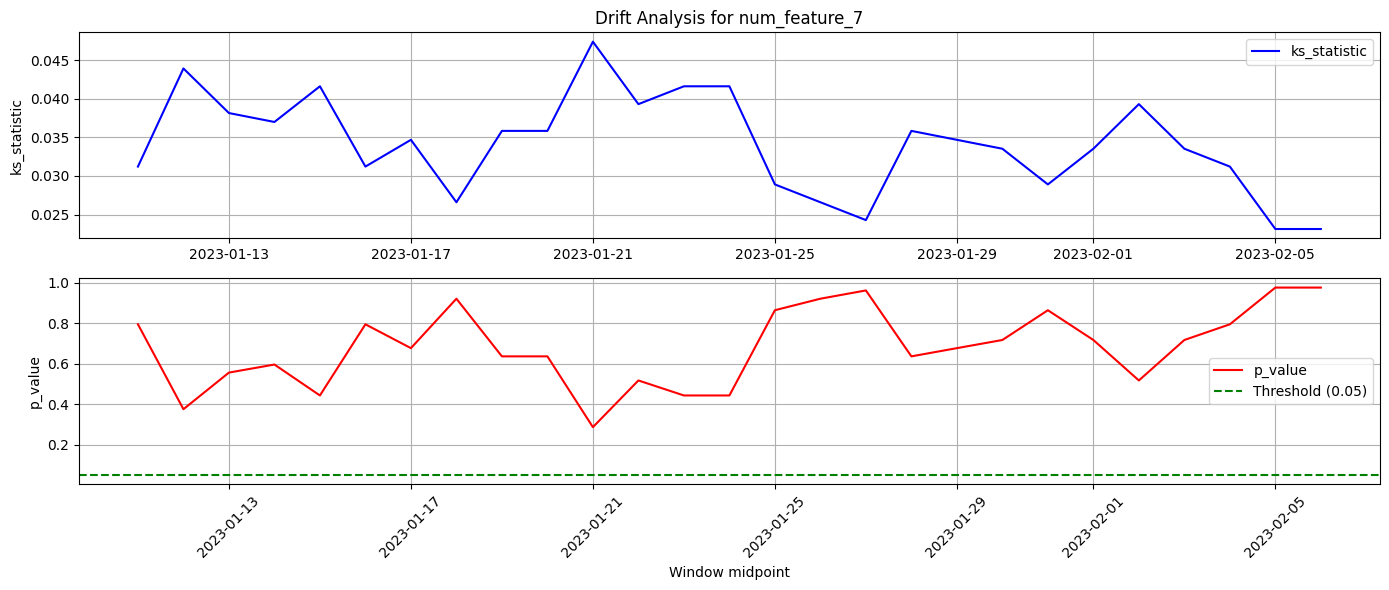

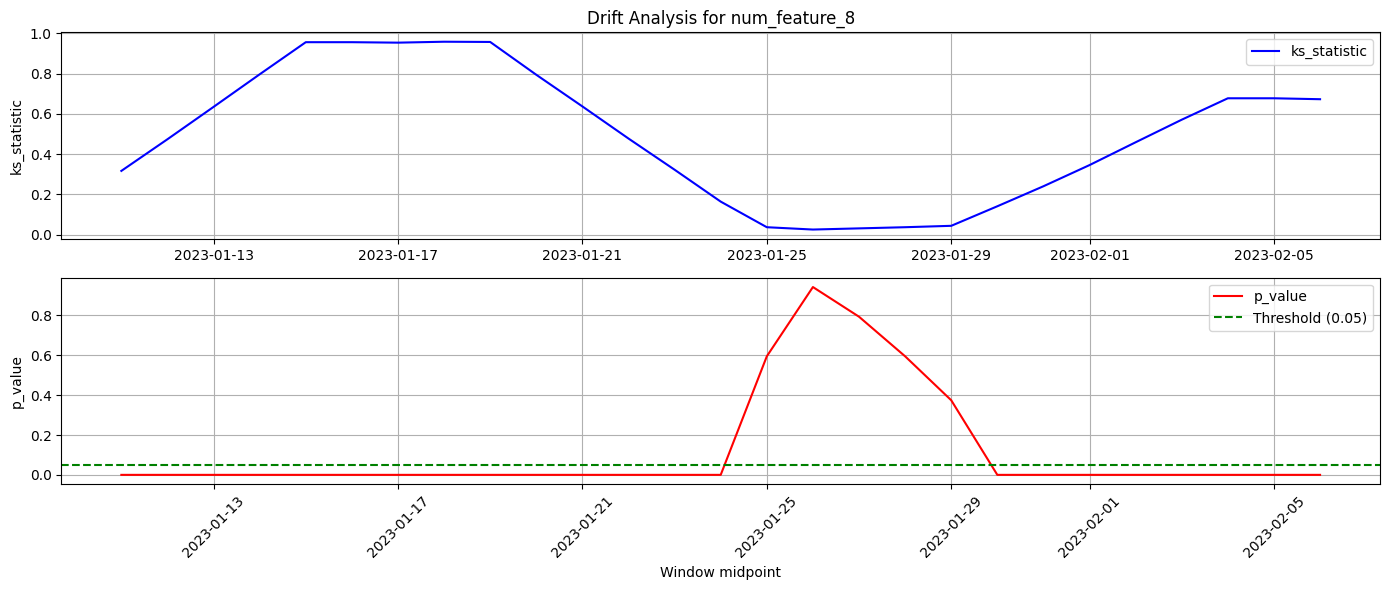

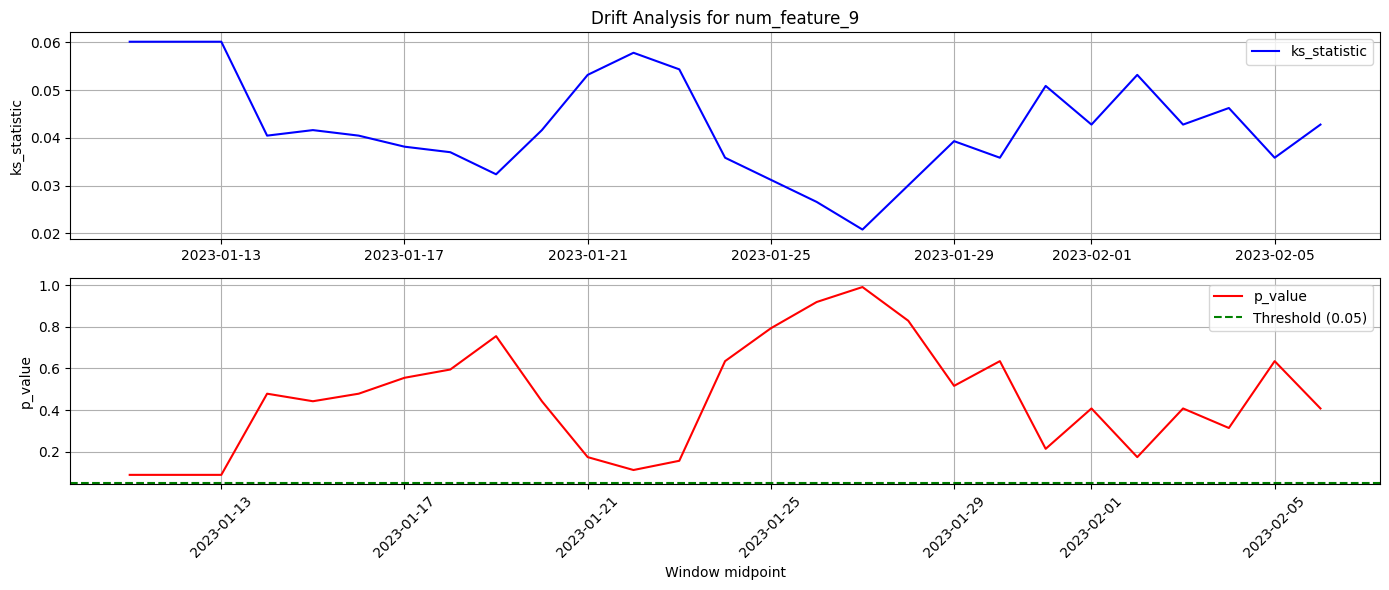

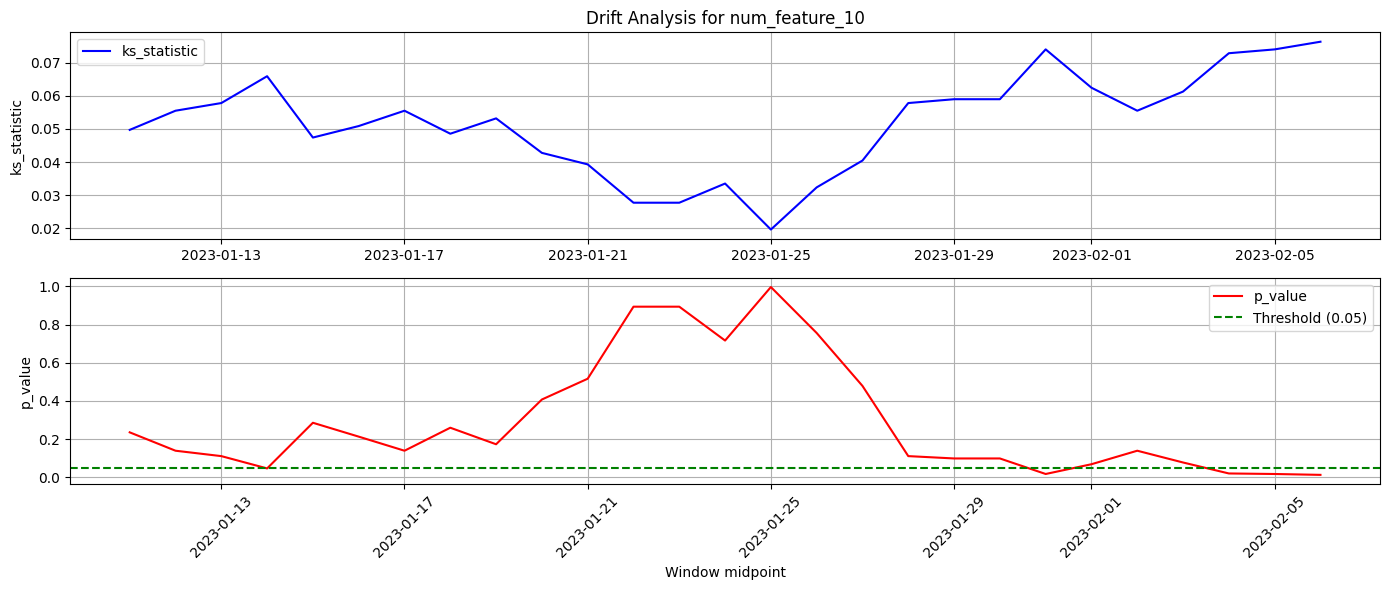

In [10]:
numerical_drift_results = {}
categorical_drift_results = {}

# Process numerical features
print("\n" + "=" * 50)
print("NUMERICAL FEATURES DRIFT ANALYSIS")
print("=" * 50)

for feature in numerical_cols:
    results = detect_numerical_drift(
        synthetic,
        feature,
        reference_start,
        reference_end,
        window_size,
        step_size,
    )
    numerical_drift_results[feature] = results
    plot_drift_metrics(
        results,
        feature,
        "ks_statistic",
        "p_value",
        threshold=0.05,
        is_numerical=True,
    )


CATEGORICAL FEATURES DRIFT ANALYSIS
Feature 'cat_feature_1' does not show significant drift (Chi-Square test).
--------------------------------------------------------------------------------
Feature 'cat_feature_2' shows drift (Chi-Square test).
First drift detected around: 2023-01-29
Total number of windows with drift: 9
Number of distinct drift periods: 1
  Drift period 1: 2023-01-29 to 2023-02-06
--------------------------------------------------------------------------------
Feature 'cat_feature_3' does not show significant drift (Chi-Square test).
--------------------------------------------------------------------------------


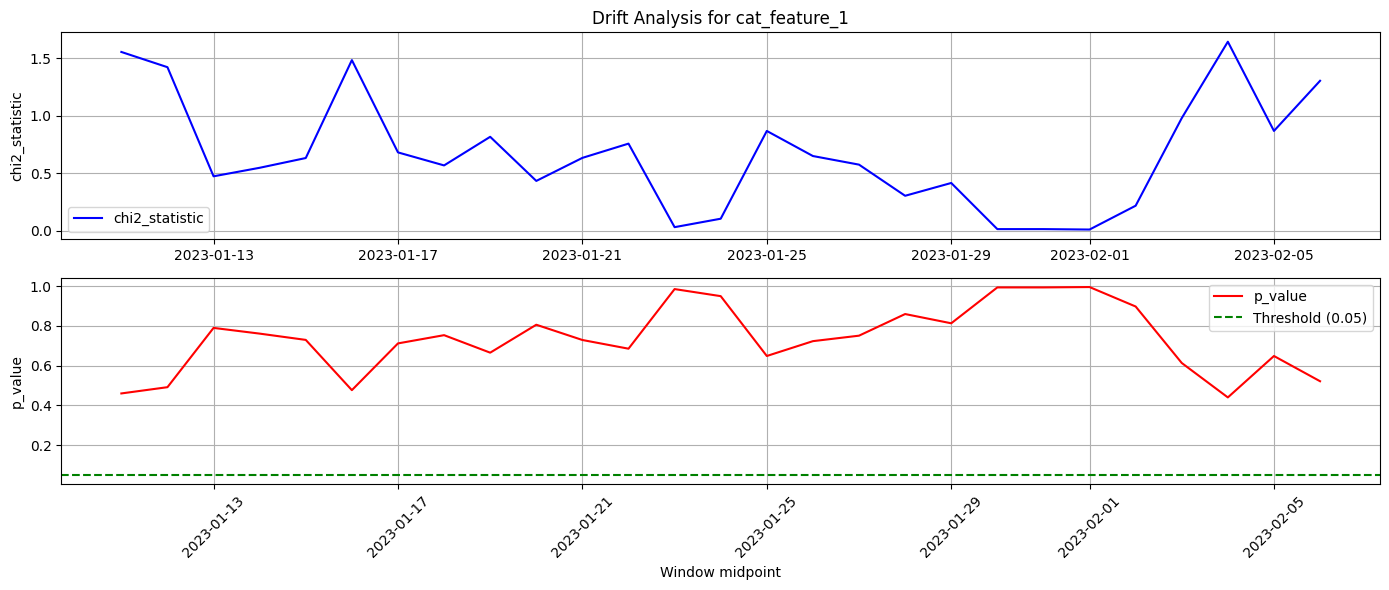

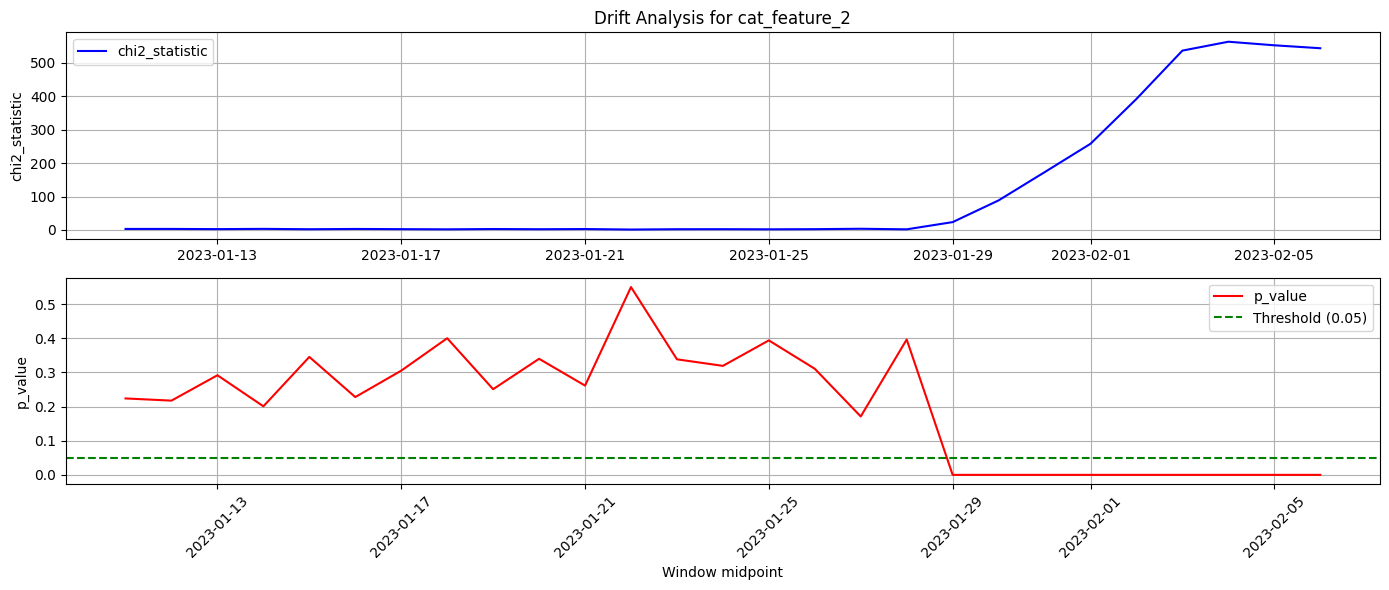

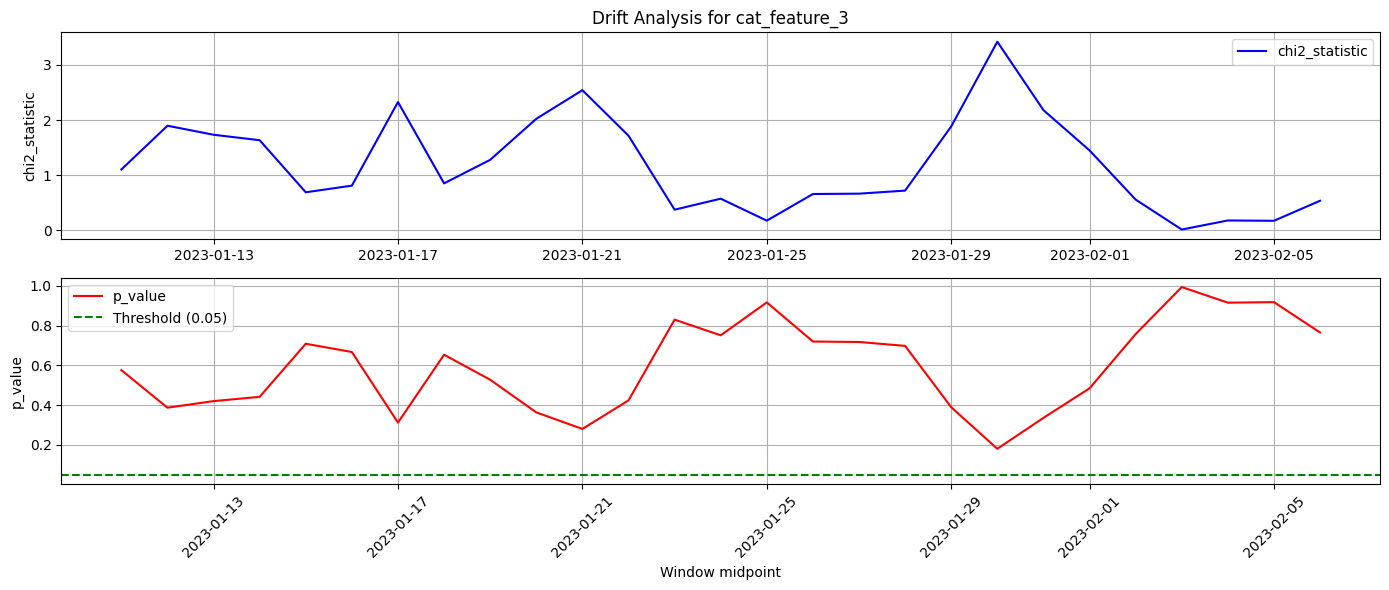

In [11]:
print("\n" + "=" * 50)
print("CATEGORICAL FEATURES DRIFT ANALYSIS")
print("=" * 50)

for feature in categorical_cols:
    results = detect_categorical_drift(
        synthetic,
        feature,
        reference_start,
        reference_end,
        window_size,
        step_size,
    )
    categorical_drift_results[feature] = results
    plot_drift_metrics(
        results,
        feature,
        "chi2_statistic",
        "p_value",
        threshold=0.05,
        is_numerical=False,
    )

In [12]:
print("\n" + "=" * 50)
print("DRIFT ANALYSIS SUMMARY")
print("=" * 50)

all_numerical_drift = {}
all_categorical_drift = {}

for feature in numerical_cols:
    results = numerical_drift_results[feature]
    drift_windows = results[results["p_value"] < 0.05]
    if len(drift_windows) > 0:
        first_drift = min(drift_windows["window_mid"])
        all_numerical_drift[feature] = {
            "first_drift_date": first_drift.date(),
            "drift_count": len(drift_windows),
        }

for feature in categorical_cols:
    results = categorical_drift_results[feature]
    drift_windows = results[results["p_value"] < 0.05]
    if len(drift_windows) > 0:
        first_drift = min(drift_windows["window_mid"])
        all_categorical_drift[feature] = {
            "first_drift_date": first_drift.date(),
            "drift_count": len(drift_windows),
        }


DRIFT ANALYSIS SUMMARY


In [13]:
print("\nNumerical features with drift:")
for feature, info in all_numerical_drift.items():
    print(
        f"- {feature}: First drift on {info['first_drift_date']}, {info['drift_count']} drift windows"
    )

print("\nCategorical features with drift:")
for feature, info in all_categorical_drift.items():
    print(
        f"- {feature}: First drift on {info['first_drift_date']}, {info['drift_count']} drift windows"
    )


Numerical features with drift:
- num_feature_3: First drift on 2023-01-20, 18 drift windows
- num_feature_5: First drift on 2023-01-14, 24 drift windows
- num_feature_8: First drift on 2023-01-11, 22 drift windows
- num_feature_10: First drift on 2023-01-14, 5 drift windows

Categorical features with drift:
- cat_feature_2: First drift on 2023-01-29, 9 drift windows


In [18]:
plot_drift_summary(
    synthetic, numerical_drift_results, categorical_drift_results
)

/var/folders/3c/x1npc5yj6655gwzm358m5plh0000gn/T/ipykernel_60656/387583952.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
